# Imports

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import random
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load data

In [2]:
train_df = pd.read_csv('/Users/khadijadial/Desktop/bttai-ajl-2025/train.csv')
test_df = pd.read_csv('/Users/khadijadial/Desktop/bttai-ajl-2025/test.csv')

# Add .jpg extension to md5hash column to reference the file_name
train_df['md5hash'] = train_df['md5hash'].astype(str) + '.jpg'
test_df['md5hash'] = test_df['md5hash'].astype(str) + '.jpg'

# Combine label and md5hash to form the correct path
train_df['file_path'] = train_df['label'] + '/' + train_df['md5hash']

In [3]:
train_df.head()

,md5hash,fitzpatrick_scale,fitzpatrick_centaur,label,nine_partition_label,three_partition_label,qc,ddi_scale,file_path
0,fd06d13de341cc75ad679916c5d7e6a6.jpg,4,4,prurigo-nodularis,benign-epidermal,benign,NaN,34,prurigo-nodularis/fd06d13de341cc75ad679916c5d7...
1,a4bb4e5206c4e89a303f470576fc5253.jpg,1,1,basal-cell-carcinoma-morpheiform,malignant-epidermal,malignant,NaN,12,basal-cell-carcinoma-morpheiform/a4bb4e5206c4e...
2,c94ce27e389f96bda998e7c3fa5c4a2e.jpg,5,5,keloid,inflammatory,non-neoplastic,1 Diagnostic,56,keloid/c94ce27e389f96bda998e7c3fa5c4a2e.jpg
3,ebcf2b50dd943c700d4e2b586fcd4425.jpg,3,3,basal-cell-carcinoma,malignant-epidermal,malignant,NaN,34,basal-cell-carcinoma/ebcf2b50dd943c700d4e2b586...
4,c77d6c895f05fea73a8f3704307036c0.jpg,1,1,prurigo-nodularis,benign-epidermal,benign,NaN,12,prurigo-nodularis/c77d6c895f05fea73a8f37043070...


In [4]:
folder_path = '/Users/khadijadial/Desktop/bttai-ajl-2025'
train_csv = os.path.join(folder_path, "train.csv")
test_csv = os.path.join(folder_path, "test.csv")
image_dir = os.path.join(folder_path, "train", "train")

# Check if the folder exists
if os.path.exists(folder_path):
  print(f"Folder '{folder_path}' found.")
else:
  print(f"Folder '{folder_path}' not found in your Google Drive.")

Folder '/Users/khadijadial/Desktop/bttai-ajl-2025' found.


# Exploratory Data Analysis


*   Find any missing values in train & test
*   Visualize class distribution of skin condition


*   Visualize skin tone distribution
*   Find underrepresented classes to create more data



Missing values in train data:
md5hash                     0
fitzpatrick_scale           0
fitzpatrick_centaur         0
label                       0
nine_partition_label        0
three_partition_label       0
qc                       2770
ddi_scale                   0
file_path                   0
dtype: int64

Missing values in test data:
md5hash                   0
fitzpatrick_scale         0
fitzpatrick_centaur       0
qc                     1198
ddi_scale                 0
dtype: int64


/var/folders/20/ymhw11495d53yqgnqzwbzr_r0000gn/T/ipykernel_26856/940732868.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=train_df['label'], order=train_df['label'].value_counts().index, palette="viridis")


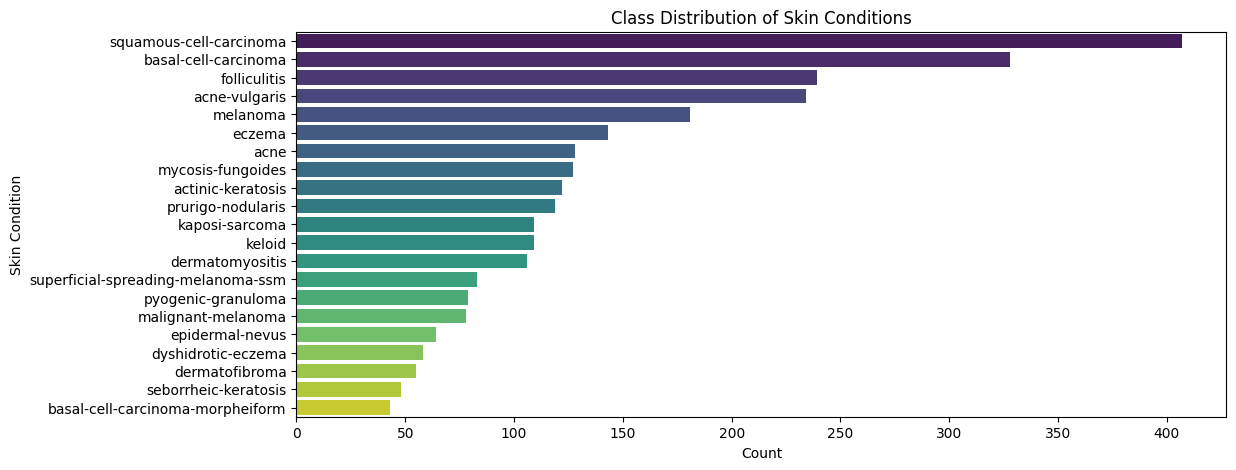

/var/folders/20/ymhw11495d53yqgnqzwbzr_r0000gn/T/ipykernel_26856/940732868.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=train_df['fitzpatrick_scale'], palette="coolwarm")


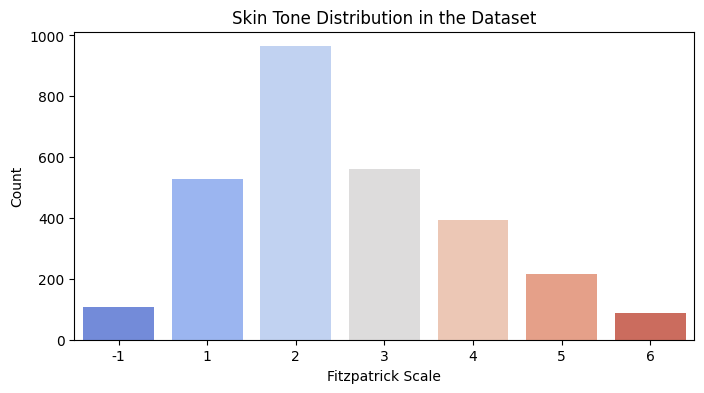

/var/folders/20/ymhw11495d53yqgnqzwbzr_r0000gn/T/ipykernel_26856/940732868.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dark_skin_df['fitzpatrick_scale'], palette="magma")


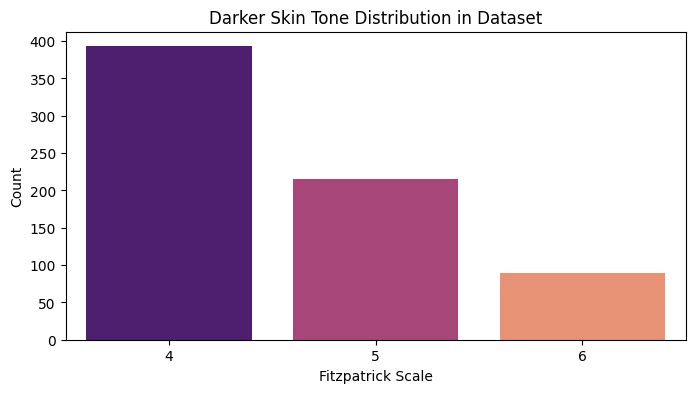

Underrepresented classes: Index(['seborrheic-keratosis', 'basal-cell-carcinoma-morpheiform'], dtype='object', name='label')


In [5]:
# Display first few rows
train_df.head()

print("Missing values in train data:")
print(train_df.isnull().sum())

print("\nMissing values in test data:")
print(test_df.isnull().sum())

plt.figure(figsize=(12, 5))
sns.countplot(y=train_df['label'], order=train_df['label'].value_counts().index, palette="viridis")
plt.title("Class Distribution of Skin Conditions")
plt.xlabel("Count")
plt.ylabel("Skin Condition")
plt.show()

plt.figure(figsize=(8, 4))
sns.countplot(x=train_df['fitzpatrick_scale'], palette="coolwarm")
plt.title("Skin Tone Distribution in the Dataset")
plt.xlabel("Fitzpatrick Scale")
plt.ylabel("Count")
plt.show()

# explore darker skin images
dark_skin_df = train_df[train_df['fitzpatrick_scale'].isin([4, 5, 6])]

# Display the count of images in each darker skin tone category
plt.figure(figsize=(8, 4))
sns.countplot(x=dark_skin_df['fitzpatrick_scale'], palette="magma")
plt.title("Darker Skin Tone Distribution in Dataset")
plt.xlabel("Fitzpatrick Scale")
plt.ylabel("Count")
plt.show()


class_counts = train_df['label'].value_counts()
underrepresented_classes = class_counts[class_counts < 50].index  # Adjust threshold as needed
print("Underrepresented classes:", underrepresented_classes)

# Data Preprocessing

In [6]:
# Add .jpg extension to md5hash column to reference the file_name
train_df['md5hash'] = train_df['md5hash'].astype(str)
test_df['md5hash'] = test_df['md5hash'].astype(str)

# Combine label and md5hash to form the correct path
train_df['file_path'] = train_df['label'] + '/' + train_df['md5hash']

# Check the first few rows to understand the structure
print(train_df.head())

                                md5hash  fitzpatrick_scale  \
0  fd06d13de341cc75ad679916c5d7e6a6.jpg                  4   
1  a4bb4e5206c4e89a303f470576fc5253.jpg                  1   
2  c94ce27e389f96bda998e7c3fa5c4a2e.jpg                  5   
3  ebcf2b50dd943c700d4e2b586fcd4425.jpg                  3   
4  c77d6c895f05fea73a8f3704307036c0.jpg                  1   

   fitzpatrick_centaur                             label nine_partition_label  \
0                    4                 prurigo-nodularis     benign-epidermal   
1                    1  basal-cell-carcinoma-morpheiform  malignant-epidermal   
2                    5                            keloid         inflammatory   
3                    3              basal-cell-carcinoma  malignant-epidermal   
4                    1                 prurigo-nodularis     benign-epidermal   

  three_partition_label            qc  ddi_scale  \
0                benign           NaN         34   
1             malignant           Na

In [7]:
# Encode the labels
label_encoder = LabelEncoder()
train_df['encoded_label'] = label_encoder.fit_transform(train_df['label'])

# Split the data into training and validation sets
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42)

# Data Augmentation

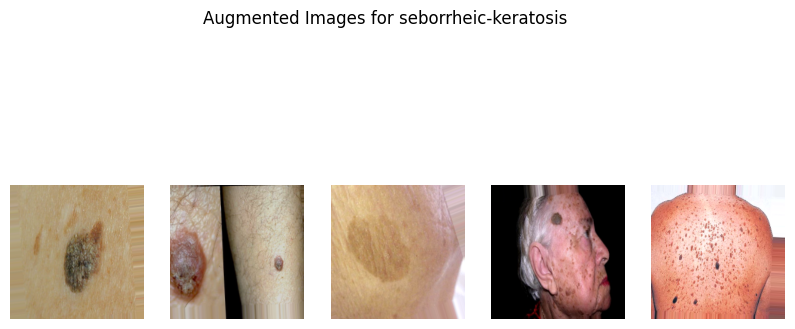

In [8]:
datagen_general = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    zoom_range=0.2
)

# Augment a class with low amounts of images
def augment_images(class_name, num_augmented=50):
    class_dir = os.path.join(image_dir, class_name)
    augmented_images = []

    for img_name in os.listdir(class_dir)[:num_augmented]:
        img_path = os.path.join(class_dir, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))  # Resize to model input size
        img = np.expand_dims(img, axis=0)  # Add batch dimension

        augmented = datagen_general.flow(img, batch_size=1)
        aug_img = next(augmented)[0].astype(np.uint8)

        augmented_images.append(aug_img)

    return augmented_images

# Show augmented images
augmented_images = augment_images(underrepresented_classes[0])

plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(augmented_images[i])
    plt.axis('off')
plt.suptitle(f"Augmented Images for {underrepresented_classes[0]}")
plt.show()

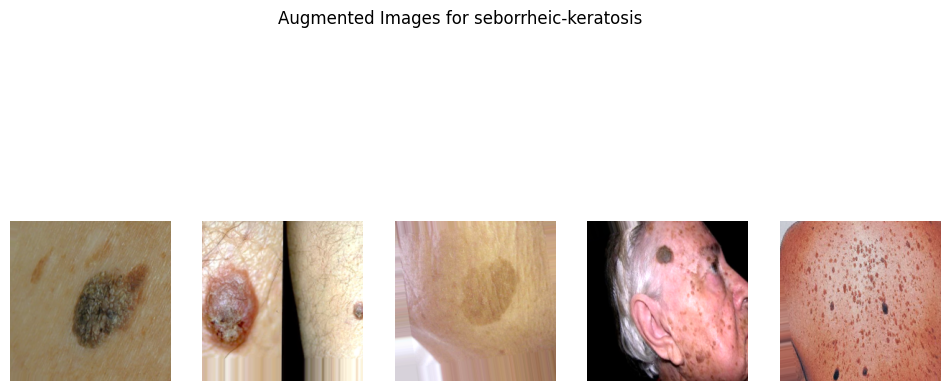

In [9]:
# Define augmentation strategy for darker skin tones
datagen_dark_skin = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=[1.0, 1.5],
    zoom_range=0.3
)

def find_image_path(image_hash):
    """Search for an image file inside the train folder's subdirectories."""
    for condition in os.listdir(image_dir):  # Loop through subfolders
        condition_path = os.path.join(image_dir, condition)

        if os.path.isdir(condition_path):
            img_path = os.path.join(condition_path, image_hash + ".jpg")

            if os.path.exists(img_path):
                return img_path  # Return first match

    # Return None and log that the file is missing
    print(f"Image with hash {image_hash}.jpg not found.")
    return None



# Function to augment darker skin images
def augment_dark_skin_images(df, num_augmented=50):
    augmented_images = []

    for _, row in df.iterrows():
        img_path = find_image_path(row['md5hash'])

        if img_path is None:
            print(f"Skipping missing file: {row['md5hash']}")
            continue

        img = cv2.imread(img_path)

        if img is None:
            print(f"Error loading image: {img_path}")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))  # Resize to match model input size
        img = np.expand_dims(img, axis=0)  # Add batch dimension

        # Apply augmentation
        augmented = datagen.flow(img, batch_size=1)
        aug_img = next(augmented)[0].astype(np.uint8)

        augmented_images.append(aug_img)

    return augmented_images

# Generate augmented images
# Show augmented images
augmented_images = augment_images(underrepresented_classes[0])

plt.figure(figsize=(12, 6))
for i, img in enumerate(augmented_images[:5]):
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.suptitle(f"Augmented Images for {underrepresented_classes[0]}")
plt.show()


# OG Model

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    BatchNormalization,
)
from tensorflow.keras.optimizers import Adam

# Define CNN Model
model = Sequential(
    [
        Conv2D(32, (3, 3), activation="relu", input_shape=(224, 224, 3)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation="relu"),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation="relu"),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation="relu"),
        Dropout(0.5),
        Dense(len(train_df["label"].unique()), activation="softmax"),
    ]
)

# Compile Model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

model.summary()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 21)             │         2,709 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,172,565 (42.62 MB)

 Trainable params: 11,172,117 (42.62 MB)

 Non-trainable params: 448 (1.75 KB)

In [19]:
# Setting Up Data Generators
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
)

train_generator = datagen.flow_from_directory(
    "/Users/khadijadial/Desktop/bttai-ajl-2025/train/train",
    target_size=(224, 224),
    batch_size=32,
    class_mode="sparse",
    subset="training",
)

val_generator = datagen.flow_from_directory(
    "/Users/khadijadial/Desktop/bttai-ajl-2025/train/train",
    target_size=(224, 224),
    batch_size=32,
    class_mode="sparse",
    subset="validation",
)

Found 2300 images belonging to 21 classes.
Found 560 images belonging to 21 classes.


In [20]:
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
)

model.save("trained_model.h5")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 49s 659ms/step - accuracy: 0.0894 - loss: 4.4915 - val_accuracy: 0.0839 - val_loss: 10.2754
Epoch 2/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 48s 661ms/step - accuracy: 0.1397 - loss: 3.0439 - val_accuracy: 0.0839 - val_loss: 14.3894
Epoch 3/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 46s 642ms/step - accuracy: 0.1579 - loss: 3.0202 - val_accuracy: 0.0839 - val_loss: 11.4208
Epoch 4/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 46s 642ms/step - accuracy: 0.1534 - loss: 3.0456 - val_accuracy: 0.0857 - val_loss: 5.4504
Epoch 5/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 47s 646ms/step - accuracy: 0.1607 - loss: 3.0250 - val_accuracy: 0.1107 - val_loss: 3.2354


In [36]:
import json

# Save the training history to a JSON file
history_dict = history.history
with open('training_history.json', 'w') as f:
    json.dump(history_dict, f)

print("Training history saved to training_history.json")

Training history saved to training_history.json


# Evaluation

18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 204ms/step
Weighted F1 Score on Validation Set: 0.0473
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        25
           1       0.09      0.46      0.15        46
           2       0.00      0.00      0.00        24
           3       0.12      0.08      0.09        65
           4       0.00      0.00      0.00         8
           5       0.00      0.00      0.00        11
           6       0.00      0.00      0.00        21
           7       0.00      0.00      0.00        11
           8       0.09      0.25      0.14        28
           9       0.00      0.00      0.00        12
          10       0.07      0.17      0.10        47
          11       0.20      0.05      0.08        21
          12       0.00      0.00      0.00        21
          13       0.00      0.00      0.00        15
          14       0.03      0.06      0.04        36
          15       0.00      0.00      0.00       

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

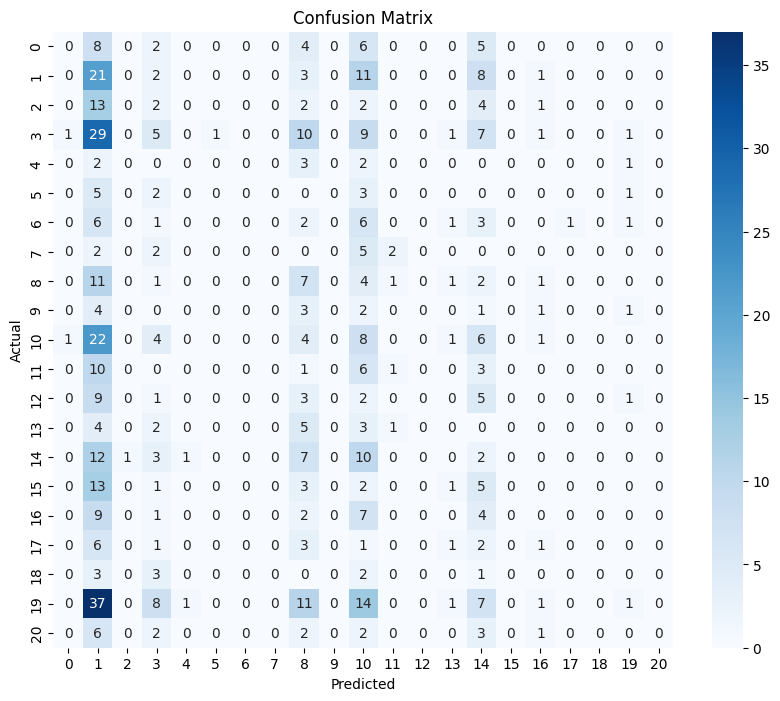

In [21]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# Predict on validation set
val_predictions = model.predict(val_generator)
val_predicted_labels = np.argmax(val_predictions, axis=1)

# Get actual labels from validation set
actual_val_labels = val_generator.classes  # Actual labels in order

# Compute weighted F1-score
f1 = f1_score(actual_val_labels, val_predicted_labels, average='weighted')
print(f"Weighted F1 Score on Validation Set: {f1:.4f}")

# Print detailed classification report
print(classification_report(actual_val_labels, val_predicted_labels))

# Confusion matrix visualization
conf_matrix = confusion_matrix(actual_val_labels, val_predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [28]:
test_image_dir = "/Users/khadijadial/Desktop/bttai-ajl-2025/test/test"

In [31]:
# Check if the directory exists and contains images
if not os.path.exists(test_image_dir):
	raise ValueError(f"Directory {test_image_dir} does not exist.")
if len(os.listdir(test_image_dir)) == 0:
	raise ValueError(f"Directory {test_image_dir} is empty.")

# Ensure the test generator is properly initialized
test_generator = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
	dataframe=test_df,
	directory=test_image_dir,
	x_col="md5hash",  # This is the file name
	y_col=None,  # No labels in test set
	target_size=(224, 224),
	batch_size=32,
	class_mode=None,
	shuffle=False
)

# Predict on test set
test_predictions = model.predict(test_generator)
test_predicted_labels = np.argmax(test_predictions, axis=1)

# Convert numerical predictions back to class names
test_df["label"] = label_encoder.inverse_transform(test_predicted_labels)


Found 1227 validated image filenames.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step


In [33]:
# Ensure the 'label' column exists in test_df
if 'label' not in test_df.columns:
	test_df['label'] = label_encoder.inverse_transform(test_predicted_labels)

submission = test_df[["md5hash", "label"]]
submission['md5hash'] = submission['md5hash'].str.replace('.jpg', '')
submission.to_csv("submission.csv", index=False)

print("Submission file saved: submission.csv")


Submission file saved: submission.csv


/var/folders/20/ymhw11495d53yqgnqzwbzr_r0000gn/T/ipykernel_6887/3824584005.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['md5hash'] = submission['md5hash'].str.replace('.jpg', '')


# Version 1 - 52%

In [49]:
# Setting Up Data Generators
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
)


train_generator = datagen.flow_from_directory(
    "/Users/khadijadial/Desktop/bttai-ajl-2025/train/train",
    target_size=(224, 224),
    batch_size=32,
    class_mode="sparse",
    subset="training",
)

val_generator = datagen.flow_from_directory(
    "/Users/khadijadial/Desktop/bttai-ajl-2025/train/train",
    target_size=(224, 224),
    batch_size=32,
    class_mode="sparse",
    subset="validation",
)

Found 2300 images belonging to 21 classes.
Found 560 images belonging to 21 classes.


In [62]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Load the InceptionV3 model pre-trained on ImageNet
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze the last 20 layers for fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(train_df['label'].unique()), activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_df['label']), y=train_df['label'])
class_weight_dict = dict(enumerate(class_weights))

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=0.00001)  # Smoother LR drop
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)  # Allow more epochs

# Train the model
history = model.fit(
    train_generator,
    epochs=15,  # Increased from 8
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    class_weight=class_weight_dict,
    callbacks=[reduce_lr, early_stopping],
)

# Save the trained model
model.save("best_fine_tuned_model.h5")

Epoch 1/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.0652 - loss: 3.1056 - val_accuracy: 0.2679 - val_loss: 2.3940 - learning_rate: 1.0000e-04
Epoch 2/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.2697 - loss: 2.4392 - val_accuracy: 0.3339 - val_loss: 2.1640 - learning_rate: 1.0000e-04
Epoch 3/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.4038 - loss: 1.8232 - val_accuracy: 0.3893 - val_loss: 2.0019 - learning_rate: 1.0000e-04
Epoch 4/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.4964 - loss: 1.4598 - val_accuracy: 0.4446 - val_loss: 1.8974 - learning_rate: 1.0000e-04
Epoch 5/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.5934 - loss: 1.0770 - val_accuracy: 0.4482 - val_loss: 1.8974 - learning_rate: 1.0000e-04
Epoch 6/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.6669 - loss: 0.8618 - val_accuracy: 0.4696 - val_loss: 1.8355 - learning_rate: 1.0000e-04
Epoch 7/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.7135 

18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 405ms/step
Weighted F1 Score on Validation Set: 0.0670
              precision    recall  f1-score   support

           0       0.03      0.04      0.04        25
           1       0.09      0.09      0.09        46
           2       0.03      0.04      0.04        24
           3       0.13      0.11      0.12        65
           4       0.00      0.00      0.00         8
           5       0.06      0.09      0.07        11
           6       0.05      0.05      0.05        21
           7       0.00      0.00      0.00        11
           8       0.12      0.14      0.13        28
           9       0.00      0.00      0.00        12
          10       0.06      0.09      0.07        47
          11       0.00      0.00      0.00        21
          12       0.00      0.00      0.00        21
          13       0.00      0.00      0.00        15
          14       0.07      0.06      0.06        36
          15       0.00      0.00      0.00       

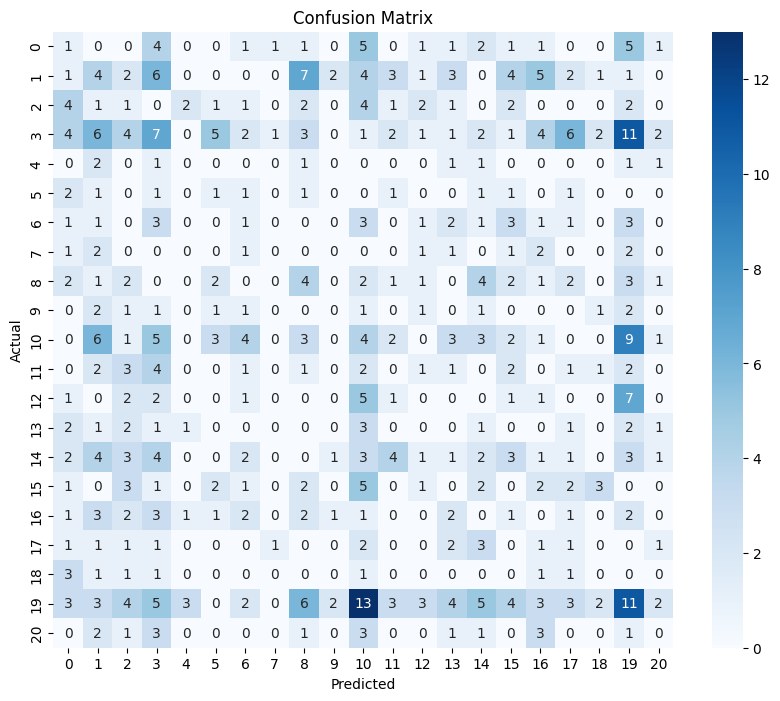

In [68]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# Predict on validation set
val_predictions = model.predict(val_generator)
val_predicted_labels = np.argmax(val_predictions, axis=1)

# Get actual labels from validation set
actual_val_labels = val_generator.classes  # Actual labels in order

# Compute weighted F1-score
f1 = f1_score(actual_val_labels, val_predicted_labels, average='weighted')
print(f"Weighted F1 Score on Validation Set: {f1:.4f}")

# Print detailed classification report
print(classification_report(actual_val_labels, val_predicted_labels))

# Confusion matrix visualization
conf_matrix = confusion_matrix(actual_val_labels, val_predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [64]:
test_image_dir = "/Users/khadijadial/Desktop/bttai-ajl-2025/test/test"

In [65]:
# Check if the directory exists and contains images
if not os.path.exists(test_image_dir):
	raise ValueError(f"Directory {test_image_dir} does not exist.")
if len(os.listdir(test_image_dir)) == 0:
	raise ValueError(f"Directory {test_image_dir} is empty.")

# Ensure the test generator is properly initialized
test_generator = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
	dataframe=test_df,
	directory=test_image_dir,
	x_col="md5hash",  # This is the file name
	y_col=None,  # No labels in test set
	target_size=(224, 224),
	batch_size=32,
	class_mode=None,
	shuffle=False
)

# Predict on test set
test_predictions = model.predict(test_generator)
test_predicted_labels = np.argmax(test_predictions, axis=1)

# Convert numerical predictions back to class names
test_df["label"] = label_encoder.inverse_transform(test_predicted_labels)


Found 1227 validated image filenames.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 17s 411ms/step


In [66]:
# Ensure the 'label' column exists in test_df
if 'label' not in test_df.columns:
	test_df['label'] = label_encoder.inverse_transform(test_predicted_labels)

submission = test_df[["md5hash", "label"]]
submission['md5hash'] = submission['md5hash'].str.replace('.jpg', '')
submission.to_csv("submission.csv", index=False)

print("Submission file saved: submission.csv")

Submission file saved: submission.csv


/var/folders/20/ymhw11495d53yqgnqzwbzr_r0000gn/T/ipykernel_25418/4268176682.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['md5hash'] = submission['md5hash'].str.replace('.jpg', '')
